# Capstone Project (Data Engineering and Intelligence Unit)

Objective: To test the level of expertise across
-	Data acquisition
-	Data analysis
-	Data Visualization
-	Data interpretation (insight generation)

Data Category: Health, Energy, Religion, Agriculture, Hospitality, Finance

Capstone Rule:
-	All datasets must be from Nigerian geography.
-	Try to make your deliverable as native to the Nigerian ecosystem as possible.
-	Be original in your deliverable.

#### Task One: Select one or more data categories, search the internet, and acquire enough geospatial and statistical dataset 
Deliverables: 
-	Acquired dataset and their referenced source 

#### Task Two: Clean and analyze the acquired dataset, generation at least 10 analytical outputs you believe are useful 
(hint: try to focus on what can help create solution, impact or business intelligence).
Deliverable: 
-	Cleaned dataset
-	Analytical report and method used

#### Task Three: Create a visualization based on the analysis done, visuals should be in both statistical charts and maps.
(hint: your output here can be either static or interactive or both)
Deliverables:
-	Statistical Chart(s)
-	Embellished map(s)

#### Task Four: Interpret maps and charts in a summarized format (no more than 500 words) providing a relatable context on how the visualization relates to reality in terms of solution, impact, or profitability 


#### Deliverables:
-	A document having all visualization with their appending interpretation



In [67]:
# import all the neccessary libary for Data Analysis and Geospatial analysis
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
import fiona
import os
from rasterio import mask
import zipfile
from shapely.geometry import Point

from datetime import datetime as dt
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Data Category: Health

In [2]:
# # download the health datsets
# !wget https://data.humdata.org/dataset/3b4a119a-309c-4d3f-900f-18a1f6ca2dfa/resource/5a3bdd13-3ada-4bf4-ac38-643390bc0562/download/nigeriahealthfacilities.json -O data/nigeriahealthfacilities.json

In [3]:
# location of folder where all files are stored
# load the health facilities dataset
Nighealth_facilities = gpd.read_file(r'data/nigeriahealthfacilities.json')

# subset the data for boorno states only
health_facilities = Nighealth_facilities[Nighealth_facilities.state_name == "Borno"]
health_facilities.head()

,id,name,global_id,alternate_name,functional_status,type,ward_code,category,timestamp,accessibility,lga_name,lga_code,state_code,state_name,geometry
0,1,G R A Nursing Home,af719462-abfd-4f47-9dc3-0987164e75ac,Nursing Home,Unknown,Primary,12413,Primary Health Center,2020-07-04T13:49:18,None,Maiduguri,124,BR,Borno,POINT (13.14832 11.82232)
1,2,Gishili Health Center,a29b0328-d844-4358-b0ab-2e120b8fb30f,Nursing Home,Functional,Primary,12413,Primary Health Center,2020-07-04T13:49:18,Unknown,Maiduguri,124,BR,Borno,POINT (13.14718 11.82161)
2,3,Lehobi Primary Health Care,b685b769-5c83-4f83-a182-00e7e1b777d8,None,Partially Functional,Primary,10207,Primary Health Center,2020-07-04T13:49:18,None,Askira Uba,102,BR,Borno,POINT (12.81628 10.70709)
3,4,Dugja Idp Camp,78e64f7a-cbb8-4357-9e64-a7e502534527,Mandara Girau Dispensary,Not Functional,Primary,10503,Primary Health Center,2020-07-04T13:49:18,Unknown,Biu,105,BR,Borno,POINT (12.18163 10.61522)
4,5,Kopa Maikudiri Dispensary,409c97ce-7490-4dc2-a8f8-2b8d53ad2b12,None,Partially Functional,Primary,10209,Dispensary,2020-07-04T13:49:18,Unknown,Askira Uba,102,BR,Borno,POINT (13.31336 10.75953)


In [4]:
# Find the total number of existing healthcare facilities
len(health_facilities)

884

In [5]:
health_facilities.columns

Index(['id', 'name', 'global_id', 'alternate_name', 'functional_status',
       'type', 'ward_code', 'category', 'timestamp', 'accessibility',
       'lga_name', 'lga_code', 'state_code', 'state_name', 'geometry'],
      dtype='object')

In [6]:
# Find the categories of healthcare facilities available
health_facilities.category.value_counts()

Primary Health Center               379
Dispensary                          340
Private Non Profit                   44
General Hospital                     31
Maternity Home                       16
Military and Paramilitary Clinic      9
Specialist Hospital                   8
Educational Clinic                    6
Others                                4
Federal Staff Clinic                  4
Comprehensive Health Center           3
Federal Medical Center                2
Medical Center                        2
Veterinary Clinic                     1
Teaching Hospital                     1
Name: category, dtype: int64

Text(0.5, 1.0, 'CATEGORIES OF EXISTING HEALTHCARE FACILITIES')

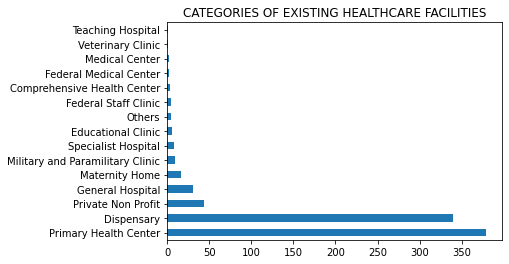

In [7]:
#visualize the categories by frequency
health_facilities.category.value_counts().plot(kind="barh");
plt.title("CATEGORIES OF EXISTING HEALTHCARE FACILITIES")
# plt.savefig(os.path.join(output,"CATEGORIES OF EXISTING HEALTHCARE FACILITIES"))

In [8]:
health_facilities.functional_status.value_counts()

Functional              673
Unknown                 162
Not Functional           42
Partially Functional      7
Name: functional_status, dtype: int64

In [9]:
# 10 lga wth the higest number of hospitals
health_facilities.lga_name.value_counts().head(10)

Maiduguri     69
Askira Uba    68
Jere          58
Gwoza         50
Damboa        48
Konduga       46
Bama          43
Biu           43
Hawul         40
Shani         40
Name: lga_name, dtype: int64

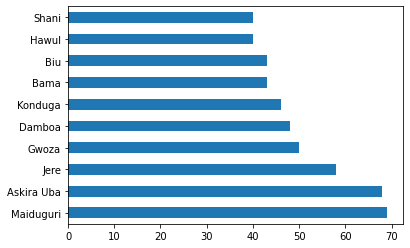

In [10]:
health_facilities.lga_name.value_counts().head(10).plot(kind='barh');

In [11]:
# 10 lga wth the least number of hospitals
health_facilities.lga_name.value_counts().tail(10)

Magumeri      21
Marte         21
Kala Balge    19
Kaga          19
Ngala         17
Nganzai       16
Mobbar        15
Guzamala      14
Gubio         14
Abadam        13
Name: lga_name, dtype: int64

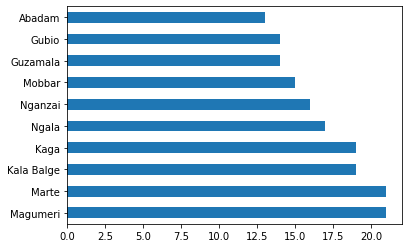

In [12]:
health_facilities.lga_name.value_counts().tail(10).plot(kind="barh");

#### Validate the Health Facilitites Data using Geospatial Technique

In [13]:
# check the spatial reference of the health facility point layer
print(health_facilities.crs)

epsg:4326


Reproject the health facility point CRS from WGS84 to UTM. 
This is needed whenever one is doing any GIS analysis that involves distance, to get the accurate distnace the data needs to be reprojected to it's local datum.

In [14]:
# reproject the health facility point CRS from WGS84 to UTM
reproj_facilities = health_facilities.to_crs(epsg=32632)
print(reproj_facilities.crs)

epsg:32632


epsg:4326


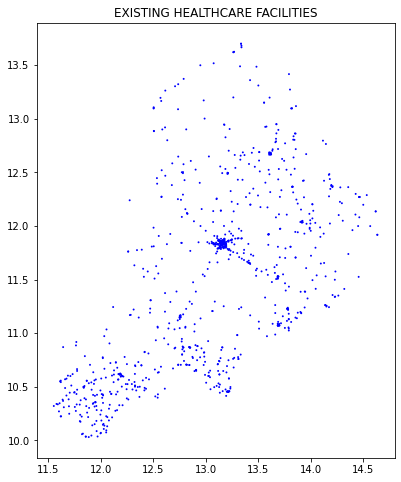

In [15]:
# Create a buffer of 500m around the healthcare faciliites
buffer_facilities =reproj_facilities.geometry.buffer(1000)
# Overlay it on a map to visualize

buffer_ = gpd.GeoDataFrame(buffer_facilities)
buffer_.rename(columns={0:"geometry"},inplace=True)
buffer_.to_crs(epsg=4326, inplace=True)
print(buffer_.crs)
buffer_.plot(color="blue",figsize=(8,8));
plt.title("EXISTING HEALTHCARE FACILITIES");
# plt.savefig(os.path.join(location,"EXISTING HEALTHCARE FACILITIES"))

In [16]:
# # Download the Nigeria Population estimate raster data from Grid3
# !wget https://wopr.worldpop.org/download/495 -O data/NGA_population_v2_0_gridded.zip

In [17]:
# zipped_file = "data/NGA_population_v2_0_gridded.zip"

def extract_zip(data):
    # directory to extract the data
    
    data_folder = "data/"

    # Extract the zip file to a directory
    with zipfile.ZipFile(data, 'r') as zip_file:
        zip_file.extractall(data_folder)
        
#extract_zip(zipped_file)

In [18]:
# # download Borno Admin boundaries shapefile
# !wget https://data.humdata.org/dataset/a1d24d7c-1341-46ce-9a61-66a57f0bd5d4/resource/00704b7f-6137-4832-852b-6ad6d7142403/download/borno_admin2_boundaries_lga.zip   -O data/borno_admin2_boundaries_lga.zip 

In [19]:
# lga ziped file
# lga_data = 'data/borno_admin2_boundaries_lga.zip'

# # extract the admin boundary 
# extract_zip(lga_data)

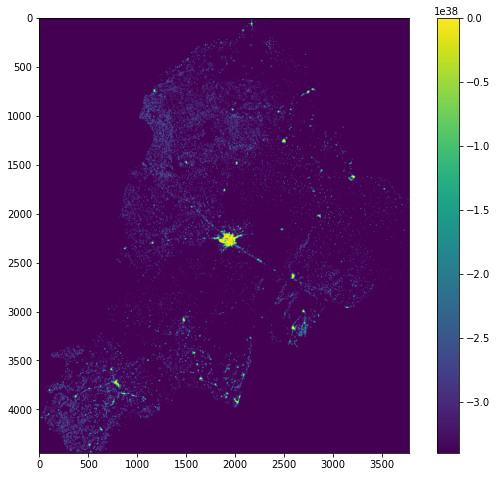

In [20]:
# Load the Borno LGA data
borno_lga = gpd.read_file('data/Borno_Admin_Boundaries_OnlyBorno_eHA_IOM_LGAs.shp')

# Merge based on 'StateCode'
state = borno_lga.dissolve(by='StateCode')

# Load the gridded raster population map using rasterio
pop_raster = "NGA_population_v2_0_gridded.tif"
raster = rasterio.open(os.path.join("data", pop_raster))

# Clip the raster data to Borno boundary data
borno_pop_raster, transform = mask.mask(raster, state["geometry"], crop=True)

# Plot the clipped raster data
plt.figure(figsize=(10, 8))
plt.imshow(borno_pop_raster[0], cmap='viridis')  # Access the clipped data using indexing
plt.colorbar(fraction=0.05)
plt.show()

In [21]:
# Total Estimated Population of Zamfara State from the raster data
pop_zamfara_sum = borno_pop_raster[borno_pop_raster > 0].sum()
print(f'The total estimated population of Borno state is {round(pop_zamfara_sum)}')

The total estimated population of Borno state is 6070348


In [22]:
# create a function that can be used to calculate zonal statistics
def zonal_stat(raster,poly):
    """"
    This function is used to compute a sum stat of a raster wihtin a particular polygon
    imagery: Raster image that will be use to compute the stat
    poly: The overlayed boundary whose stat will be computed    
    Return: list contain sum of pixel of the raster within each define poly
    """
    _results = []
    for i in poly["geometry"]:
        aoi = poly[poly["geometry"]== i]

        # using the mask.mask module from Rasterio to specify the ROI
        gtraster, bound = mask.mask(raster, aoi["geometry"], crop=True) 
        
        # values greater than 0 represent the estimated population count for that pixel
        _results.append(round(gtraster[gtraster > 0].sum()))

    return _results

In [23]:
# Use the 1000m buffer around the health facilities to compute the total estiimated population within the radium of 1km of the clinic
df1 = zonal_stat(raster,buffer_)
buffer_["Population within 1000m radius"] = df1
buffer_["id"] = reproj_facilities["id"]

In [98]:
# Join the attribute of the clinic to the buffer created around it so as to be able to identify the buffer of each clinic
pop_health_fc = buffer_.merge(reproj_facilities, on ="id")

# drop unwanted columns
pop_health_fc.drop(['global_id',  'alternate_name' ,
       'ward_code', 'accessibility', 'lga_code', 'state_code','geometry_x'], axis = 1, inplace = True)
pop_health_fc.head()

,Population within 1000m radius,id,name,functional_status,type,category,timestamp,lga_name,state_name,geometry_y
0,12730,1,G R A Nursing Home,Unknown,Primary,Primary Health Center,2020-07-04T13:49:18,Maiduguri,Borno,POINT (952240.436 1310264.751)
1,12910,2,Gishili Health Center,Functional,Primary,Primary Health Center,2020-07-04T13:49:18,Maiduguri,Borno,POINT (952116.692 1310184.703)
2,1621,3,Lehobi Primary Health Care,Partially Functional,Primary,Primary Health Center,2020-07-04T13:49:18,Askira Uba,Borno,POINT (917601.224 1186179.501)
3,30499,4,Dugja Idp Camp,Not Functional,Primary,Primary Health Center,2020-07-04T13:49:18,Biu,Borno,POINT (848184.257 1175216.864)
4,1827,5,Kopa Maikudiri Dispensary,Partially Functional,Primary,Dispensary,2020-07-04T13:49:18,Askira Uba,Borno,POINT (972003.367 1192711.890)


In [26]:
# Top 20 health facilities withinn 1000m radium of highly populated area
top_20 = pop_health_fc[["name", 'functional_status',"Population within 1000m radius",
                        "category","lga_name"]].nlargest(20,"Population within 1000m radius")
top_20

,name,functional_status,Population within 1000m radius,category,lga_name
558,Yerwa Clinic,Functional,113583,Primary Health Center,Maiduguri
164,Bogum Dispensary,Functional,105842,Dispensary,Maiduguri
145,Shehus Palace Clinic,Functional,101138,Private Non Profit,Maiduguri
171,Fhi360 Clinic,Functional,92477,Private Non Profit,Maiduguri
676,Nana Kashim Clinic,Functional,91168,None,Maiduguri
97,Vital Registration Center Zanna Umarti,Functional,81598,Primary Health Center,Maiduguri
167,Unicef Clinic,Functional,76346,Private Non Profit,Maiduguri
243,Gamboru Clinic,Functional,75813,Primary Health Center,Maiduguri
645,Bulabulin Dispensary,Functional,70912,Dispensary,Maiduguri
509,Gambaru Clinic,Functional,70658,Primary Health Center,Maiduguri


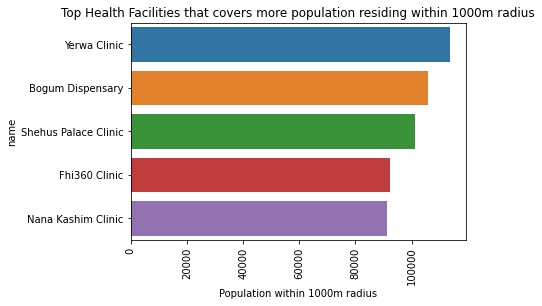

In [30]:
# Top 5 health facilities withinn 1000m radium of highly populated area
top_5 = pop_health_fc[["name", 'functional_status',"Population within 1000m radius","category","lga_name"]].nlargest(5,"Population within 1000m radius")
ax = sns.barplot(data=top_5,y="name",x="Population within 1000m radius", orient='h' );
ax.tick_params(axis='x', rotation=90)
ax.set(title ="Top Health Facilities that covers more population residing within 1000m radius");

In [31]:
# 20 health facilities that covers the lowest population within 100m
lowest_20 = pop_health_fc[["name", 'functional_status',"Population within 1000m radius",
                           "category","lga_name"]].nsmallest(20,"Population within 1000m radius")
lowest_20

,name,functional_status,Population within 1000m radius,category,lga_name
177,Jere Dispensary,Functional,0,Dispensary,Bama
205,Ngabu Dispensary,Unknown,0,Dispensary,Marte
221,Dabar Masara Health Clinic,Not Functional,0,None,Kukawa
223,Dipchari Dispensary,Not Functional,0,Primary Health Center,Bama
359,Alhajiri Primary Health Clinic,Unknown,0,Primary Health Center,Konduga
419,Mukhtari Health Clinic,Unknown,0,Primary Health Center,Mafa
502,Jewu Primary Health Clinic,Functional,0,Primary Health Center,Konduga
179,Briyel Maternal and Child Health,Unknown,2,Primary Health Center,Bama
458,Jebra Health Center,Unknown,2,Primary Health Center,Bama
412,Mairami Health Clinic,Functional,4,Primary Health Center,Konduga


Ater uisng the 500m radius buffer to extract the count of population within 500m radius of each facilities, it was noted that some faciltiites have zero population around it which seems imposiiblle, to vertify this we overlaid our health facilities data on a high resolution imagery, from there we were able to see that the points wiht zero population are invalid because the points fall on forest area and faarm lands.

we will remove all the non-existing\invalid points from the data that will be used for the suitablity and health facilities assesment

In [46]:
def validate_facilities(facilities, threshold):
    facilities["Status"] = facilities["Population within 1000m radius"].apply(lambda x: "Valid" if x > threshold else "Invalid")
    return facilities


health_validation = validate_facilities(pop_health_fc,100)

In [99]:
# total number of valid facilitites based
len (health_validation[health_validation.Status == "Valid"])

832

In [100]:
# total number of invalid facilitites based
len (health_validation[health_validation.Status == "Invalid"])

52

In [101]:
health_validation.groupby(by = ['Status','name',"lga_name"]).sum()

Population within 1000m radius  \
Status  name                           lga_name                                     
Invalid 777 Estate Clinic              Kala Balge                              20   
        Abduri Primary Health Clinic   Mafa                                    22   
        Ackome Polytechnic Clinic      Kukawa                                  70   
        Ajiri Health Clinic            Konduga                                 25   
        Alhajiri Primary Health Clinic Konduga                                  0   
...                                                                           ...   
Valid   Zari Health Clinic             Mobbar                                 682   
        Zengebe Dispensry              Mafa                                   751   
        Zonal Health Office            Maiduguri                            44031   
        Zowo Model Health Center       Gubio                                  630   
        Zuma Kumogun Dispensary        Nganzai                                461   

                                                    id  
Status  name                           lga_name         
Invalid 777 Estate Clinic              Kala Balge  210  
        Abduri Primary Health Clinic   Mafa        405  
        Ackome Polytechnic Clinic      Kukawa      118  
        Ajiri Health Clinic            Konduga     373  
        Alhajiri Primary Health Clinic Konduga     360  
...                                                ...  
Valid   Zari Health Clinic             Mobbar      576  
        Zengebe Dispensry              Mafa        528  
        Zonal Health Office            Maiduguri   238  
        Zowo Model Health Center       Gubio       561  
        Zuma Kumogun Dispensary        Nganzai     404  

[878 rows x 2 columns]

In [102]:
borno_lga.head()

,OBJECTID,LGACode,LGAName,StateCode,Timestamp,GlobalID,AMAPCODE,LGA_PCODE,State_PCod,Source,Alt_LGANam,SHAPE_Leng,SHAPE_Area,geometry
0,1.0,102,Askira-Uba,BR,2015/09/30 08:44:38.000,{C4176F0A-C0C0-4304-81DE-1F4FCB8EF6C8},NIE BOS ASU,NGA008002,NGA008,eHA-STAFF,Askira / Uba,3.061810,0.240370,"POLYGON ((13.27451 10.88961, 13.28385 10.87861..."
1,2.0,103,Bama,BR,2015/08/08 11:30:41.000,{E8BC1CEB-857C-4421-ADC6-542C2FC34A02},NIE BOS BAM,NGA008003,NGA008,eHA-STAFF,Bama,2.675484,0.321993,"POLYGON ((14.26499 11.78649, 14.25146 11.71317..."
2,3.0,104,Bayo,BR,2016/08/19 11:26:02.000,{4BDDF4FB-84CF-40E4-8451-46C4BA505A98},NIE BOS BAY,NGA008004,NGA008,eHA-STAFF,Bayo,1.943713,0.093129,"POLYGON ((11.83490 10.66101, 11.83054 10.66030..."
3,4.0,105,Biu,BR,2016/08/19 11:26:02.000,{272A8E9C-BB9F-45D9-B726-BD44D96D7AE9},NIE BOS BBU,NGA008005,NGA008,eHA-STAFF,Biu,2.889217,0.261148,"POLYGON ((12.15308 11.11954, 12.31448 11.02199..."
4,5.0,106,Chibok,BR,2015/09/30 08:44:38.000,{9DECBEA8-D569-47A9-B61F-38A241E1EF4D},NIE BOS CBK,NGA008006,NGA008,eHA-STAFF,Chibok,1.478003,0.116826,"POLYGON ((12.82828 10.96355, 12.82828 10.96355..."


In [ ]:
# Set the CRS for the GeoDataFrame
health_gdf = gpd.GeoDataFrame(health_validation, geometry='geometry')
health_gdf.crs = 32632 # Replace 'your_current_crs' with the CRS of your original data

# Convert the CRS
health_gdf = health_gdf.to_crs(epsg=4326)

In [128]:
# Perform spatial join between Borno LGA and validated health facilities
borno_lga_with_facilities = gpd.sjoin(borno_lga, health_gdf, how='left', op='intersects')
borno_lga_with_facilities.head()

grouped_facilities = borno_lga_with_facilities.groupby(['LGAName', 'Status']).size().reset_index(name='Count')
grouped_facilities = grouped_facilities.pivot_table(index='LGAName', columns='Status', values='Count', fill_value=0).reset_index()

# merge grouped data with Borno LGA data
borno_lga_merged = borno_lga.merge(grouped_facilities, on='LGAName', how='left')
borno_lga_merged.head()

,OBJECTID,LGACode,LGAName,StateCode,Timestamp,GlobalID,AMAPCODE,LGA_PCODE,State_PCod,Source,Alt_LGANam,SHAPE_Leng,SHAPE_Area,geometry,Invalid,Valid
0,1.0,102,Askira-Uba,BR,2015/09/30 08:44:38.000,{C4176F0A-C0C0-4304-81DE-1F4FCB8EF6C8},NIE BOS ASU,NGA008002,NGA008,eHA-STAFF,Askira / Uba,3.061810,0.240370,"POLYGON ((13.27451 10.88961, 13.28385 10.87861...",1,69
1,2.0,103,Bama,BR,2015/08/08 11:30:41.000,{E8BC1CEB-857C-4421-ADC6-542C2FC34A02},NIE BOS BAM,NGA008003,NGA008,eHA-STAFF,Bama,2.675484,0.321993,"POLYGON ((14.26499 11.78649, 14.25146 11.71317...",9,34
2,3.0,104,Bayo,BR,2016/08/19 11:26:02.000,{4BDDF4FB-84CF-40E4-8451-46C4BA505A98},NIE BOS BAY,NGA008004,NGA008,eHA-STAFF,Bayo,1.943713,0.093129,"POLYGON ((11.83490 10.66101, 11.83054 10.66030...",0,34
3,4.0,105,Biu,BR,2016/08/19 11:26:02.000,{272A8E9C-BB9F-45D9-B726-BD44D96D7AE9},NIE BOS BBU,NGA008005,NGA008,eHA-STAFF,Biu,2.889217,0.261148,"POLYGON ((12.15308 11.11954, 12.31448 11.02199...",0,43
4,5.0,106,Chibok,BR,2015/09/30 08:44:38.000,{9DECBEA8-D569-47A9-B61F-38A241E1EF4D},NIE BOS CBK,NGA008006,NGA008,eHA-STAFF,Chibok,1.478003,0.116826,"POLYGON ((12.82828 10.96355, 12.82828 10.96355...",0,33


In [131]:
borno_lga_merged.columns

Index(['OBJECTID', 'LGACode', 'LGAName', 'StateCode', 'Timestamp', 'GlobalID',
       'AMAPCODE', 'LGA_PCODE', 'State_PCod', 'Source', 'Alt_LGANam',
       'SHAPE_Leng', 'SHAPE_Area', 'geometry', 'Invalid', 'Valid'],
      dtype='object')

In [135]:
borno_lga_facilities = borno_lga_merged[['LGAName', 'Invalid', 'Valid', 'geometry']]
borno_lga_facilities.head()

,LGAName,Invalid,Valid,geometry
0,Askira-Uba,1,69,"POLYGON ((13.27451 10.88961, 13.28385 10.87861..."
1,Bama,9,34,"POLYGON ((14.26499 11.78649, 14.25146 11.71317..."
2,Bayo,0,34,"POLYGON ((11.83490 10.66101, 11.83054 10.66030..."
3,Biu,0,43,"POLYGON ((12.15308 11.11954, 12.31448 11.02199..."
4,Chibok,0,33,"POLYGON ((12.82828 10.96355, 12.82828 10.96355..."


In [181]:
borno_lga_facilities['Percentage of invalid'] = round(borno_lga_facilities['Invalid']/(borno_lga_facilities['Valid']+borno_lga_facilities['Invalid']) *100)
borno_lga_facilities.head()

,LGAName,Invalid,Valid,geometry,Percentage of invalid,lga_population,coords,population per healthcare
0,Askira-Uba,1,69,"POLYGON ((13.27451 10.88961, 13.28385 10.87861...",1.0,329181,POINT (12.94846 10.67806),4771.0
1,Bama,9,34,"POLYGON ((14.26499 11.78649, 14.25146 11.71317...",21.0,258106,POINT (14.00342 11.51838),7591.0
2,Bayo,0,34,"POLYGON ((11.83490 10.66101, 11.83054 10.66030...",0.0,202314,POINT (11.70050 10.43750),5950.0
3,Biu,0,43,"POLYGON ((12.15308 11.11954, 12.31448 11.02199...",0.0,371166,POINT (12.10606 10.81111),8632.0
4,Chibok,0,33,"POLYGON ((12.82828 10.96355, 12.82828 10.96355...",0.0,132901,POINT (12.83163 10.84903),4027.0


In [170]:
# compute the poulation within each lga
lga_pop = zonal_stat(raster,borno_lga_facilities)
borno_lga_facilities["lga_population"] = lga_pop
borno_lga_facilities["population per healthcare"] = round(borno_lga_facilities['lga_population']/borno_lga_facilities['Valid'])
borno_lga_facilities.head()

,LGAName,Invalid,Valid,geometry,Percentage of invalid,lga_population,coords,population per healthcare
0,Askira-Uba,1,69,"POLYGON ((13.27451 10.88961, 13.28385 10.87861...",1.0,329181,POINT (12.94846 10.67806),4771.0
1,Bama,9,34,"POLYGON ((14.26499 11.78649, 14.25146 11.71317...",26.0,258106,POINT (14.00342 11.51838),7591.0
2,Bayo,0,34,"POLYGON ((11.83490 10.66101, 11.83054 10.66030...",0.0,202314,POINT (11.70050 10.43750),5950.0
3,Biu,0,43,"POLYGON ((12.15308 11.11954, 12.31448 11.02199...",0.0,371166,POINT (12.10606 10.81111),8632.0
4,Chibok,0,33,"POLYGON ((12.82828 10.96355, 12.82828 10.96355...",0.0,132901,POINT (12.83163 10.84903),4027.0


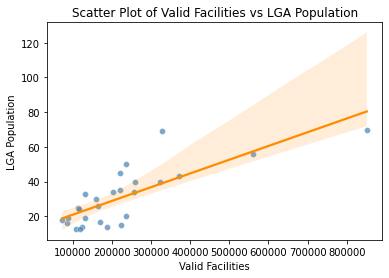

In [171]:
sns.scatterplot(data=borno_lga_facilities,x='lga_population', y='Valid', color='steelblue', alpha=0.7)
sns.regplot(data=borno_lga_facilities,x='lga_population', y='Valid', scatter=False, color='darkorange')
plt.xlabel('Valid Facilities')
plt.ylabel('LGA Population')
plt.title('Scatter Plot of Valid Facilities vs LGA Population')

plt.show()

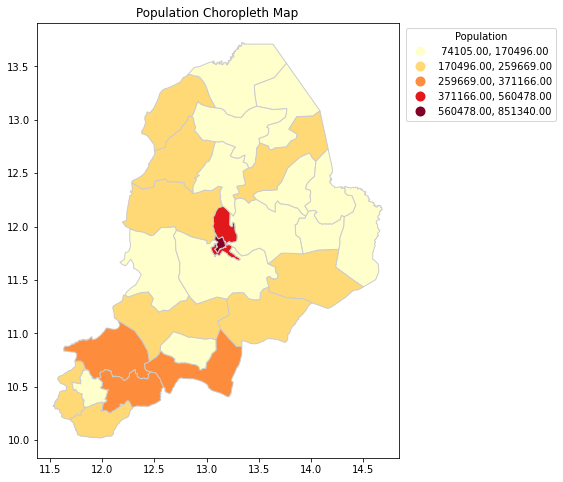

In [177]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the choropleth map
borno_lga_facilities.plot(column='lga_population', scheme='NaturalBreaks',cmap = 'YlOrRd',
                          legend=True, ax=ax, legend_kwds={'loc': 'best'})
# Customize the legend
legend = ax.get_legend()
legend.set_title('Population')
legend.set_bbox_to_anchor((1.45,1))

# Set a proper color scheme
cmap = 'YlOrRd'
borno_lga_facilities.plot(column='lga_population', scheme='NaturalBreaks', cmap=cmap, ax=ax,edgecolor='0.8')

# Set plot title
ax.set_title('Population Choropleth Map')
# Show the plot
plt.show()

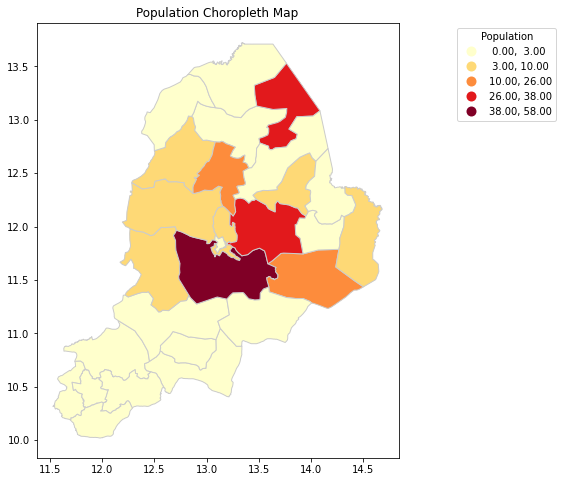

In [176]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the choropleth map
borno_lga_facilities.plot(column='Percentage of invalid', scheme='NaturalBreaks',cmap = 'YlOrRd',
                          legend=True, ax=ax, legend_kwds={'loc': 'best'})
# Customize the legend
legend = ax.get_legend()
legend.set_title('Population')
legend.set_bbox_to_anchor((1.45,1))

# Set a proper color scheme
cmap = 'YlOrRd'
borno_lga_facilities.plot(column='Percentage of invalid', scheme='NaturalBreaks', cmap=cmap, ax=ax,edgecolor='0.8')

# Set plot title
ax.set_title('Population Choropleth Map')
# Show the plot
plt.show()

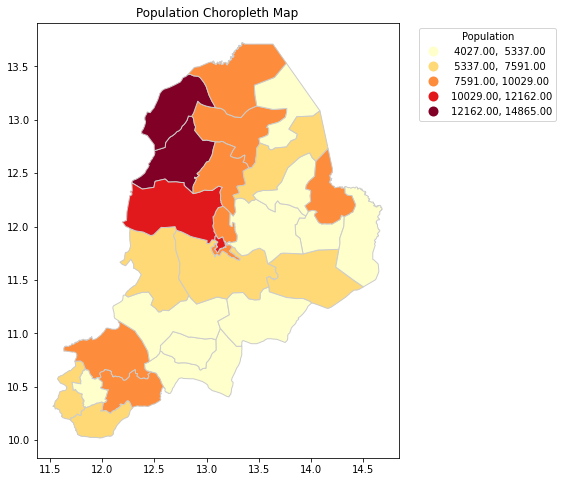

In [175]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the choropleth map
borno_lga_facilities.plot(column='population per healthcare', scheme='NaturalBreaks',cmap = 'YlOrRd',
                          legend=True, ax=ax, legend_kwds={'loc': 'best'})
# Customize the legend
legend = ax.get_legend()
legend.set_title('Population')
legend.set_bbox_to_anchor((1.45,1))

# Set a proper color scheme
cmap = 'YlOrRd'
borno_lga_facilities.plot(column='population per healthcare', scheme='NaturalBreaks', cmap=cmap, ax=ax,edgecolor='0.8')

# Set plot title
ax.set_title('Population Choropleth Map')
# Show the plot
plt.show()

In [185]:
# Epxort datasets
borno_lga_facilities.to_csv('data/borno_lga_with_facilities.csv', index = False)
health_gdf.to_csv('data/health_validated.csv', index = False)

## Data Category: Hospitality